In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
df = pd.read_excel('virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.iloc[15:,:].reset_index(drop=True)
rapid_growth=rapid_growth.dropna().reset_index(drop=True)
rapid_growth['Cured_total']=rapid_growth[['Cured_change']].cumsum()
rapid_growth['Dead_total']=rapid_growth[['Dead_change']].cumsum()
rapid_growth['R_total']=rapid_growth['Cured_total']+rapid_growth['Dead_total']
rapid_growth['Total']=10000000 - rapid_growth['R_total'] - rapid_growth['Hubei']

In [3]:
data_y = rapid_growth[['Total','Suspected','Hubei','R_total']].astype('float').to_numpy().ravel()
data_y
data_t = rapid_growth.index.values+45

In [4]:
rapid_growth

,Date,Confirmed,Suspected,Cured_change,Dead_change,Hubei,Cured_total,Dead_total,R_total,Total
0,2020-01-20,291,127.0,0.0,0.0,270.0,0.0,0.0,0.0,9999730.0
1,2020-01-21,440,260.0,2.0,1.0,375.0,2.0,1.0,3.0,9999622.0
2,2020-01-22,571,393.0,4.0,3.0,444.0,6.0,4.0,10.0,9999546.0
3,2020-01-23,830,1072.0,6.0,8.0,549.0,12.0,12.0,24.0,9999427.0
4,2020-01-24,1287,1965.0,3.0,16.0,729.0,15.0,28.0,43.0,9999228.0
5,2020-01-25,1975,2684.0,11.0,15.0,1052.0,26.0,43.0,69.0,9998879.0
6,2020-01-26,2744,5794.0,2.0,24.0,1423.0,28.0,67.0,95.0,9998482.0
7,2020-01-27,4515,6973.0,9.0,26.0,2714.0,37.0,93.0,130.0,9997156.0
8,2020-01-28,5974,9239.0,43.0,26.0,3554.0,80.0,119.0,199.0,9996247.0
9,2020-01-29,7711,12167.0,38.0,38.0,4586.0,118.0,157.0,275.0,9995139.0


beta = 0.62198
sigma = 0.391955
gamma = 0.12


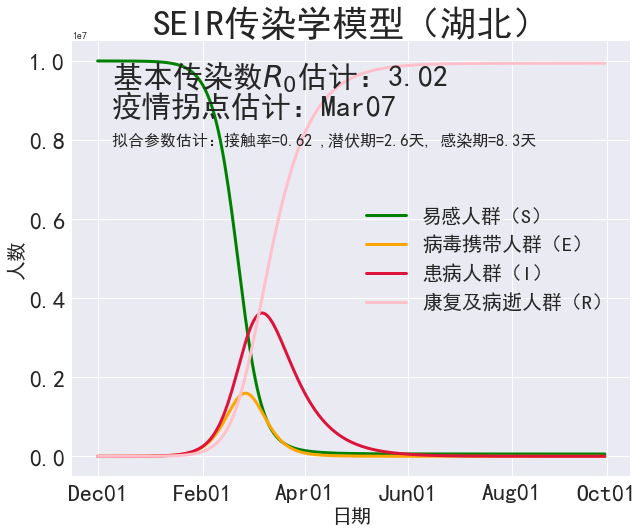

In [6]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
# The SIR model differential equations.
N = 10000000
def deriv(y, t, beta, sigma ,gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]
def yfunc(t, beta, sigma, gamma):
    y0 = [10000000-225, 200, 25, 0]
    y = odeint(deriv, y0, t, args=(beta, sigma, gamma))
    return y.ravel()

initial_parameters = [1, 0.15, 0.125]
popt, cov = curve_fit(yfunc, data_t, data_y, initial_parameters, bounds = ((0.25, 0.15, 0.12), ( 5, 0.5, 0.4)))
beta_opt, sigma_opt, gamma_opt= popt


print("beta = %g" % beta_opt)
print("sigma = %g" % sigma_opt)
print("gamma = %g" % gamma_opt)
# print("y0 = %g" % y0_opt)

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
t = np.linspace(0, 150, 300)

# Generate time range 
numdays = len(t)
stpatientdate = '2019/12/01'
datelist = pd.date_range(start = stpatientdate, periods=numdays)
lissss = [x.strftime("%b%d") for x in datelist.date]
plt.plot(lissss, yfunc(t, beta_opt, sigma_opt, gamma_opt)[0::4], '-', color='green' ,linewidth=3 ,label='易感人群（S）')
plt.plot(lissss, yfunc(t, beta_opt, sigma_opt, gamma_opt)[1::4], '-',color='orange', linewidth=3,label='病毒携带人群（E）')
plt.plot(lissss, yfunc(t, beta_opt, sigma_opt, gamma_opt)[2::4], '-' ,color='crimson', linewidth=3,label='患病人群（I）')
plt.plot(lissss, yfunc(t, beta_opt, sigma_opt, gamma_opt)[3::4], '-', color='pink', linewidth=3, label='康复及病逝人群（R）')
import datetime
deltat = pd.Timestamp(rapid_growth.Date.values[-1]).to_pydatetime() - datetime.datetime.strptime(stpatientdate,"%Y/%m/%d")
expgrowth_rate = np.log(rapid_growth.Hubei.values[-1])/deltat.days
R0_estimate = (1+expgrowth_rate/sigma_opt)*(1+expgrowth_rate/gamma_opt)
turnindex=yfunc(t, beta_opt, sigma_opt, gamma_opt)[2::4].argmax()
turntime = lissss[turnindex]
#####
# Plot
#####
plt.gcf().set_size_inches(10, 8)
plt.legend(prop={'size': 20})
plt.ylabel("人数", fontsize=20)
plt.xlabel("日期", fontsize=20)
plt.title("SEIR传染学模型（湖北）", fontsize=36)
plt.figtext(.18, .8, r"基本传染数$R_0$估计：{}".format(round(R0_estimate,2)),fontsize=30,ha='left')
plt.figtext(.18, .75, "疫情拐点估计：{}".format(turntime),fontsize=30,ha='left')
plt.figtext(.18, .7, "拟合参数估计：接触率={} ,潜伏期={}天, 感染期={}天".format(round(beta_opt,2), round(1/sigma_opt,1), round(1/gamma_opt,1)),fontsize=16,ha='left')
ax = plt.gca()
ax.set_xticks(['Dec01','Feb01','Apr01','Jun01','Aug01','Oct01'])
# ax.set_xlabels([‘two’, ‘four’,’six’, ‘eight’, ‘ten’])
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
plt.savefig('SEIR.png')
plt.show()

#### Simple demonstration of how to use curve_fit to numerically fit the virus spread

a = 4077.85
b = 0.493161


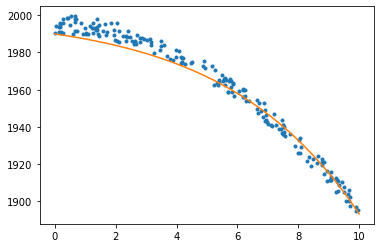

In [158]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def f(y0, t, N, beta):
#     print(y0)
    S = y0[0]
    I = y0[1]
#     S = y[0]
#     I = y[1]
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N
    return [dSdt,dIdt]

def y(t, N, beta):
#     print(N,beta)
    y0 = [1990, 10]
    """
    Solution to the ODE y'(t) = f(t,y, N, beta) with initial condition y(0) = y0
    """
    y = odeint(f, y0, t, args=(N, beta))
    return y.ravel()

# Some random data to fit
np.random.seed(seed=1)
data_t = np.sort(np.random.rand(200) * 10)
data_I = data_t**2+ np.random.rand(200)*10
data_S = 2000 - data_I
data_y= [list(pair) for pair in zip(data_S, data_I)]
# data_y = np.append(np.array(data_S), np.array(data_I))
data_y = np.asarray(data_y).ravel()
initial_parameters = [2000, 0.5]
popt, cov = curve_fit(y, data_t, data_y, initial_parameters, bounds=(0,[400000,40]))
a_opt, b_opt= popt

print("a = %g" % a_opt)
print("b = %g" % b_opt)
# print("y0 = %g" % y0_opt)

import matplotlib.pyplot as plt
t = np.linspace(0, 10, 2000)
plt.plot(data_t, data_y[0::2], '.',
         t, y(t, a_opt, b_opt)[0::2], '-')
# plt.plot(data_t, data_y[1::2], '.',
#          t, y(t, a_opt, b_opt)[1::2], '-')
plt.gcf().set_size_inches(6, 4)
plt.savefig('out.png', dpi=96)
plt.show()